# Entropy measures for determining predictability

The relative entropy and the permutation entropy.

In [131]:
import numpy as np
import simulations
import matplotlib.pyplot as plt
import scipy.stats as ss
from collections import Counter
from math import factorial,sqrt
from proficiency_metrics import rmse
import json


/Users/Marieke_Wesselkamp/PycharmProjects/Ricker/models.py:157: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


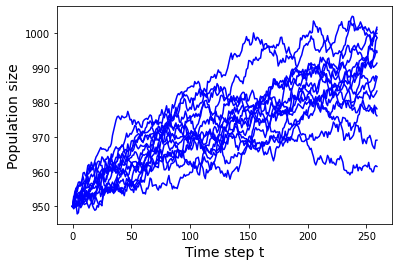

In [132]:
# create simulator object
sims = simulations.Simulator(model_type="single-species",
                             simulation_regime="non-chaotic",
                             environment="non-exogeneous")
# Set hyperparameters. We'll simulate on a weekly resolution. Years is changed to weeks.
sims.hyper_parameters(simulated_years=5,
                           ensemble_size=15,
                           initial_size=950)
x_mod = sims.simulate()


In [133]:
def embed(x, m, d = 1):
    """
    Pennekamp 2019
    """
    n = len(x) - (m-1)*d
    X = np.arange(len(x))
    if n <= 0:
        raise ValueError("Not enough observations for required embedding.")
    out = np.array([X[np.arange(n)]]*m)
    a = np.repeat(np.arange(1, m)*d, out.shape[1])
    out[1:,] = out[1:,]+a.reshape(out[1:,].shape)
    out = x[out]

    return out

def entropy(wd):
    """
    in bits
    """
    return -np.sum(list(wd.values())*np.log2(list(wd.values())))


def word_distr(x_emb, tie_method='average'):

    words = [np.array2string(ss.rankdata(x_emb[:, i])) for i in range(x_emb.shape[1])]
    c = dict(Counter(words))
    for k, v in c.items():
        c[k] = v/len(words)
    return c


def permutation_entropy(x, m, d):

    x_emb = embed(x, m=m)
    wd = word_distr(x_emb)
    denom = np.log2(2 * factorial(m))
    ent = entropy(wd) / denom

    return ent


def relative_entropy(p, q, integral = True):

    prob_frac = p/q
    RE = np.sum(p*np.log(prob_frac)) if integral else p*np.log(prob_frac)

    return RE

In [134]:
print(x_mod.shape)
PEs = [ permutation_entropy(x_mod[i].flatten(), m=3, d=1) for i in range(x_mod.shape[0])]
print(PEs)

(15, 260)


AttributeError: 'DataArray' object has no attribute 'flatten'

Now let's calculate the PE over time: Does it change over time? We do it for every ensemble member in the perfect model world.

/var/folders/s8/rp7pfvm507qcvckzx566r47c0000gp/T/ipykernel_68813/869536136.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


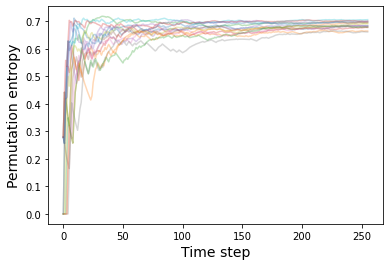

In [123]:
run=True # takes very long, better just load old results

if run:
    PEs = []
    for tau in range(4,x_mod.shape[1]): # start at 4, otherwise not enough data for embedding.
        PE = [ permutation_entropy(x_mod[i,:tau].flatten(), m=3, d=1) for i in range(x_mod.shape[0])]
        PEs.append(PE)

    PE_dic = {'PEs':PEs}
    with open('PE.json', 'w') as fp:
        json.dump(PE_dic, fp)
else:
    with open('PE.json') as json_file:
        PEs_n = json.load(json_file)

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(np.array(PEs), alpha=0.3)
ax.set_xlabel('Time step', size=14)
ax.set_ylabel('Permutation entropy', size=14)
fig.show()

The PE which seems to be very low at the beginning first steeply increases: This must be due to the still not complete permutation set, as we increase the timeseries stepwise. Interesting is the PE were it seems to start converging. There, we have apparently a more stable sense of the information that is contained in the ts and also a relatively stable frequency distribution.

Where the entropy increases, the predictability decreases. Based on the findings of Pennekamp et al., for a perfect model we expect to find a strong correlation between forecast error (FE) and permutation entropy  (PE) (to be precise: the weighted permutation entropy!). As FE, the authors pick a standardised RMSE.

In the perfect model setting, we get the FE by evaluating one trajectory against another in a bootstrapping procedure.



/var/folders/s8/rp7pfvm507qcvckzx566r47c0000gp/T/ipykernel_68813/274416411.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


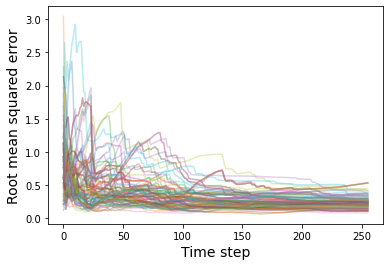

In [124]:

def rmse(y, y_pred, standardized = False):
    if standardized: # pennekamp
        return sqrt(np.square(np.subtract(y, y_pred)).mean()) / (np.max(y) - np.min(y))
    else:
        return sqrt(np.square(np.subtract(y,y_pred)).mean())

bs_samples=100
RMSEs = []
for bs in range(bs_samples):
    obs_ind, pred_ind = np.random.randint(x_mod.shape[0], size=2)
    while obs_ind == pred_ind:
        obs_ind, pred_ind = np.random.randint(x_mod.shape[0], size=2)
    x_obs = x_mod[obs_ind].flatten()
    x_pred = x_mod[pred_ind].flatten()

    RMSE = [ rmse(x_obs[:i], x_pred[:i], standardized=True) for i in range(4,x_mod.shape[1])]
    RMSEs.append(RMSE)

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(np.transpose(np.array(RMSEs)), alpha=0.3)
ax.set_xlabel('Time step', size=14)
ax.set_ylabel('Root mean squared error', size=14)
fig.show()

In [126]:
print(np.array(PEs).shape)
print(np.mean(np.array(RMSEs), axis=0).flatten().shape)

corr = np.corrcoef(np.mean(np.array(PEs), axis=1).flatten(), np.mean(np.array(RMSEs), axis=0).flatten() )
print(corr[1,0])

(256, 15)
(256,)
-0.8189565693663824


What is the intrinsic predictability of the model trajectories, compared to the real world trajectories? Is it higher because of less noise or is it lower because of missing information in the ts?
What Pennekamp et al. found was that FE and PE are correlated for a perfect model. Is that the case for an imperfect model? And if so, then how to we quantify FE?

Relative Permutation entropy: Similar Information?
Optimal PE: Optimization of m and tau.


/Users/Marieke_Wesselkamp/PycharmProjects/Ricker/models.py:157: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


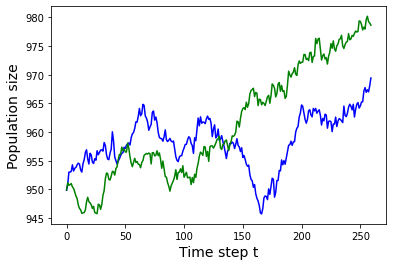

In [127]:
# create simulator object
sims = simulations.Simulator()
# Set hyperparameters. We'll simulate on a weekly resolution. Years is changed to weeks.
sims.hyper_parameters(simulated_years=5,
                           ensemble_size=1,
                           initial_size=(950, 950)) # here we have to give init for both populations
sims.simulation_parameters(regime="non-chaotic", behaviour="stochastic")
sims.environment('non-exogeneous', trend=False)
sims.model_type("multi-species")
x_true = sims.simulate()
x_true = x_true[:,:,0]

/var/folders/s8/rp7pfvm507qcvckzx566r47c0000gp/T/ipykernel_68813/96072657.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


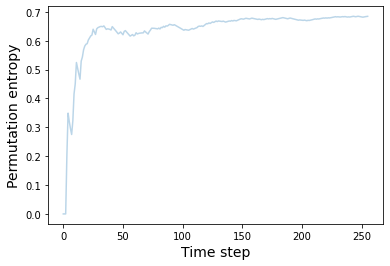

In [128]:
PE = [ permutation_entropy(x_true.flatten()[:tau], m=3, d=1) for tau in range(4, x_true.shape[1])]

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(np.array(PE), alpha=0.3)
ax.set_xlabel('Time step', size=14)
ax.set_ylabel('Permutation entropy', size=14)
fig.show()

We evaluate every forecast trajectory against our real data.

/var/folders/s8/rp7pfvm507qcvckzx566r47c0000gp/T/ipykernel_68813/41074999.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


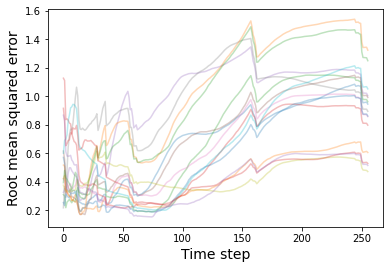

In [129]:
RMSEs = []
for m in range(x_mod.shape[0]):
    x_obs = x_true.flatten()
    x_pred = x_mod[m,:].flatten()
    RMSE = [ rmse(x_obs[:i], x_pred[:i], standardized=True) for i in range(4,x_mod.shape[1])]
    RMSEs.append(RMSE)

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(np.transpose(np.array(RMSEs)), alpha=0.3)
ax.set_xlabel('Time step', size=14)
ax.set_ylabel('Root mean squared error', size=14)
fig.show()

In [130]:
print(PE)

corr = np.corrcoef(np.mean(np.array(PEs[:776]), axis=1).flatten(), np.mean(np.array(RMSEs), axis=0).flatten() )
print(corr)
print(corr[1,0])

[-0.0, -0.0, -0.0, 0.2013767493361892, 0.34913312681403036, 0.3204593783198054, 0.29603604619173696, 0.27515677738118915, 0.32267552288603857, 0.4159359685785363, 0.4502154381055714, 0.5247181134340098, 0.5041489057958163, 0.484877855131481, 0.4668932911735326, 0.5294597567722718, 0.5436982576195688, 0.5686979298814328, 0.5817286224912582, 0.5879652047686965, 0.5898842821062584, 0.6027984775375954, 0.6096680588393169, 0.6166589838520207, 0.6198205673999859, 0.6399509127383123, 0.6309381503889898, 0.6217793879983932, 0.6412701843404162, 0.6454525083379685, 0.6472469553657209, 0.6493137987190555, 0.6496358596314965, 0.6486295390759476, 0.6514727995194605, 0.6455230414246953, 0.6393572462743224, 0.6413288709618239, 0.6407568447124178, 0.6393652813426328, 0.6373139359388114, 0.6490711776110163, 0.6443692196575087, 0.6394828679716017, 0.634456256912614, 0.6293257390561615, 0.6241213732575027, 0.6267207518398753, 0.6305341656934792, 0.6256800250020947, 0.6207772245237337, 0.6322326648667764,